In [2]:
import numpy as np
from os.path import expanduser
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from joblib import Parallel, delayed

import numpy as np  
import pandas as pd
import xarray as xr

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Load data

In [3]:
region = "la_or_ve"
data = xr.load_dataset(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/data.nc"))
data

<xarray.Dataset>
Dimensions:      (datetime: 9417, location_id: 1046)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * location_id  (location_id) object '61982' '62064' ... '351628' '351634'
    lat          (location_id) float64 34.02 33.84 34.07 ... 33.81 33.75 33.83
    lon          (location_id) float64 -118.5 -118.3 -118.2 ... -118.3 -118.3
Data variables:
    value        (datetime, location_id) float64 10.12 nan 48.81 ... 12.73 14.1

In [18]:
def train_test_for_ts(train_data, test_data, ts):
    train_df = train_data.sel(datetime=ts).to_dataframe()
    train_df = train_df.dropna(subset=["value"]).reset_index()
    
    test_df = test_data.sel(datetime=ts).to_dataframe()
    test_df = test_df.dropna(subset=["value"]).reset_index()
    
    model = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=0)
    model.fit(train_df[["lat", "lon"]], train_df["value"])
    
    pred_y = model.predict(test_df[["lat", "lon"]])
    test_df["pred"] = pred_y
    return test_df

test_dfs = []
for fold_id in range(5):
    print(f"Fold {fold_id}")
    test_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/test_{fold_id}.npy"))
    train_locs = np.load(expanduser(f"~/aqmsp/projects/better_interpol/data/purpleair/{region}/train_{fold_id}.npy"))
    
    train_data = data.sel(location_id=train_locs)
    test_data = data.sel(location_id=test_locs)
    
    out = Parallel(n_jobs=48)(delayed(train_test_for_ts)(train_data, test_data, ts) for ts in tqdm(data.datetime.values))
    
    test_df = pd.concat(out)
    test_dfs.append(test_df)

Fold 0


  0%|          | 0/9417 [00:00<?, ?it/s]

Fold 1


  0%|          | 0/9417 [00:00<?, ?it/s]

Fold 2


  0%|          | 0/9417 [00:00<?, ?it/s]

Fold 3


  0%|          | 0/9417 [00:00<?, ?it/s]

Fold 4


  0%|          | 0/9417 [00:00<?, ?it/s]

In [27]:
all_test_df = pd.concat(test_dfs)
all_test_df = all_test_df.set_index(["datetime", "location_id"])

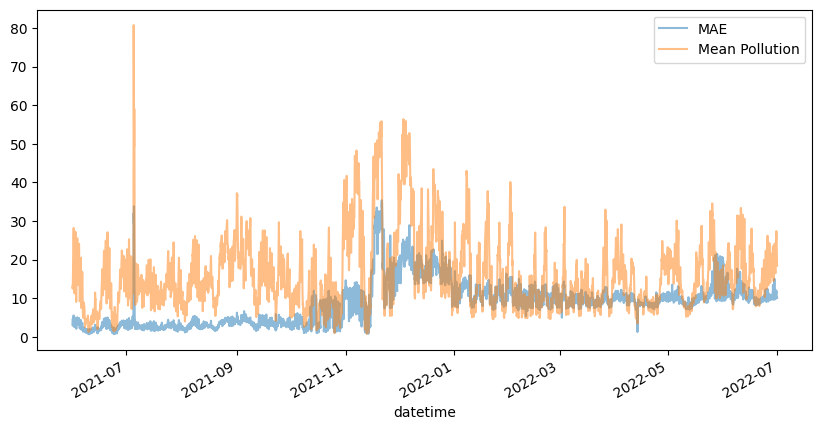

In [29]:
# compute MAE for each time step
all_test_df["abs_error"] = np.abs(all_test_df["value"] - all_test_df["pred"])

# Compute absolute percentage error
values = np.array(all_test_df["value"].values)
# add a small value to avoid division by zero
# values[values < 0.1] = 0.1
# all_test_df["abs_pct_error"] = all_test_df["abs_error"] / values

fig, ax = plt.subplots(figsize=(10, 5))
all_test_df.groupby("datetime").mean()["abs_error"].plot(ax=ax, color="C0", label="MAE", alpha=0.5)
all_test_df.groupby("datetime").mean()["value"].plot(ax=ax, color="C1", label="Mean Pollution", alpha=0.5)
# all_test_df.groupby("datetime").mean()["abs_pct_error"].plot(ax=ax, color="C1", label="MAPE")
ax.legend()

### Addional insights

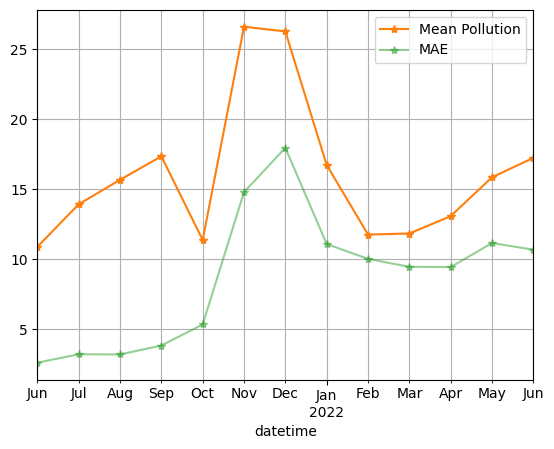

In [46]:
all_test_df.groupby("datetime").mean().resample("1M").mean()["value"].plot(marker="*", label="Mean Pollution", color="C1")
all_test_df.groupby("datetime").mean().resample("1M").mean()["abs_error"].plot(marker="*", color="C2", label="MAE", alpha=0.5)
plt.grid(which="both")
plt.legend()

In [44]:
all_test_df.abs_error.mean()

8.609654032786635

## Manual insights

RF: 8.6096